In [3]:
using ValidatedNumerics, FastTransforms
include("figures-preamble.jl")
using ApproxFun, Poltergeist

ARGS[1] = "2048"
include("../data/Lanford-preamble.jl")

Done defs: 2048


In [8]:
using JLD
prec = 8round(Int,(N+512)*0.2/8)
setprecision(prec)
# S_norm = 10
run(`unzip -o /Users/johnwormell/Documents/Spectral/Lanford-S$N.zip`)# var/tmp/Lanford-S$N.jld`)
# run(`unzip -o ../data/Lanford-$N.zip var/tmp/Lanford-$N-S.jld`)

ld = load("tmp/tmppdy794/Lanford-S2048.jld");
run(`rm tmp/tmppdy794/Lanford-S2048.jld`);

Archive:  /Users/johnwormell/Documents/Spectral/Lanford-S2048.zip
  inflating: tmp/tmppdy794/Lanford-S2048.jld  


In [9]:
println(Lsum_norm)
println(S_norm)
println(exp(log_Enorm(N)))
println(exp(log_scerr_norm(N)))

[2077.59, 2077.6]₅₁₂
[9234.74, 9234.75]₅₁₂
[6.74652e-133, 6.74653e-133]₅₁₂
[6.23024e-129, 6.23025e-129]₅₁₂


### Find rho

In [10]:
setprecision(prec)
rho_hi = ld["hi"][:,1]; rho_lo = ld["lo"][:,1];
rho_coefs = [ValidatedNumerics.Interval(rho_lo[i],rho_hi[i]) for i = 1:N]
Nr = 500
BV_err = exp(log_scerr_norm(N)) + dot(2Nr+1:2:2N-1,diam.(rho_coefs[Nr+1:end]))
rho_BV_norm = exp(log_scerr_norm(N)) + dot(1:2:2N-1,[x.hi for x in rho_coefs[1:end]])
rho_coefs = rho_coefs[1:Nr]

total_BV_err = BV_err + dot(1:2:2Nr-1,diam.(rho_coefs))
println(total_BV_err)

[6.23024e-129, 6.23025e-129]₅₁₂


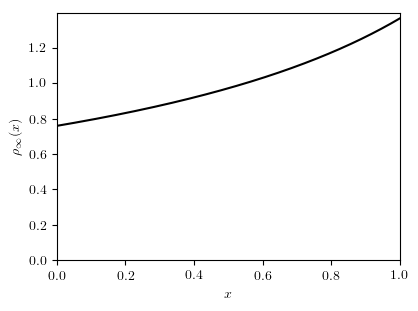

In [11]:
figure(figsize=(5*0.75/0.7*0.8,3.75*0.75/0.7*0.8))

sp = Chebyshev(Segment(0,1))
rho_fun = Fun(sp,Float64.(mid.(rho_coefs)))
pts = points(sp,1000)
plot(pts,Float64.(rho_fun.(pts)),"k")
xlim(0,1); ylim(ymin=0)
xlabel("\$x\$"); ylabel("\$\\rho\_\{\\infty\}(x)\$")
tight_layout()
savefig("../figures/rigorous-1.eps")

### Lyapunov exponent

In [12]:
M = nextpow2(div(N,8))
cheb_pts = (ApproxFun.chebyshevpoints(ValidatedNumerics.Interval{BigFloat},M)+1)/2;
lyap_coefs = gen_dct(log((@biginterval 5/2)-cheb_pts));
lyap_linfty = (@biginterval 5/2)
lyap_err_linfty = @biginterval(36/7*log(36/5)*(2/9)^M);

In [13]:
setprecision(prec)
lyap_prod = zeros(eltype(rho_coefs),M+Nr-1)
for i = 1:M
    for j = 1:Nr
        prod_cf = lyap_coefs[i] * rho_coefs[j] / 2
        lyap_prod[i+j-1] += prod_cf
        lyap_prod[abs(i-j)+1] += prod_cf
    end
end

# Chebyshev matrices
generate_T(N) = [@biginterval 2;FastTransforms.interlace(zeros(cld(N-1,2)),2./[@biginterval -(4x^2-1) for x in 1:fld(N-1,2)])]/2

# get Lyapunov exponent w/ error bound
lyap = dot(generate_T(Nr+M-1),lyap_prod)

[0.657661, 0.657662]₅₁₂

In [14]:
lyap_est = round(mid(lyap),128)
lyap_err = max(lyap-lyap_est).hi + (lyap_linfty * BV_err + lyap_err_linfty * norm(rho_coefs,1)).hi;

In [15]:
@printf "%0.128f" lyap_est
println("")
@printf "%0.129f" convert(Float64,lyap_err)

0.65766178000659767754158241382383206574324106958001220195395280269163266611155402375955645975291517482964215633179802630148859489
0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000017

### Variance

In [16]:
Fun(x->x^2,Chebyshev(Segment(0,1)))

Fun(Chebyshev(【0.0,1.0】),[0.375,0.5,0.125])

In [17]:
A_coefs = [@biginterval(3/8); @biginterval(1/2);@biginterval(1/8);fill(@biginterval(0),Nr-2)]
A_infinity_norm = 1; A_dash_infinity_norm = 2
setprecision(prec)
A_prod = zeros(eltype(rho_coefs),Nr+2)
for i = 1:3
    for j = 1:Nr
        prod_cf = A_coefs[i] * rho_coefs[j] / 2
        A_prod[i+j-1] += prod_cf
        A_prod[abs(i-j)+1] += prod_cf
    end
end
# Chebyshev matrices
generate_T(N) = [@biginterval 2;FastTransforms.interlace(zeros(cld(N-1,2)),2./[@biginterval -(4x^2-1) for x in 1:fld(N-1,2)])]/2

# get (Ar) average
A_average = dot(generate_T(Nr+2),A_prod)
Az_coefs =A_prod - A_average * [rho_coefs;0;0]

SAz_coefs = zeros(ValidatedNumerics.Interval{BigFloat},N)
for j = 1:N
    for k = 1:Nr+2
        SAz_coefs[j] += ValidatedNumerics.Interval(ld["lo"][j,k],ld["hi"][j,k])*Az_coefs[k]
    end
end

#Setting ρ = R + E we have $Aρ -<A,ρ>ρ - (Ar - <A,r>r) = A(ρ-r) - <A,ρ-r>ρ - <A,r>(ρ-r)
Az_BV_err = A_infinity_norm * total_BV_err + A_dash_infinity_norm * total_BV_err +
        A_average*total_BV_err*rho_BV_norm + A_infinity_norm*total_BV_err
SAz_BV_err = S_norm*Az_BV_err

[2.78618e-124, 2.78619e-124]₅₁₂

In [20]:
ASAz_prod = zeros(eltype(rho_coefs),N+2)
for i = 1:N
    for j = 1:3
        prod_cf = SAz_coefs[i] * A_coefs[j] / 2
        ASAz_prod[i+j-1] += prod_cf
        ASAz_prod[abs(i-j)+1] += prod_cf
    end
end

# get Lyapunov exponent w/ error bound
ASAz = dot(generate_T(N+2),ASAz_prod)
ASAz_fromBV_err = A_infinity_norm * SAz_BV_err

AAz_prod = zeros(eltype(rho_coefs),N+2)
for i = 1:Nr
    for j = 1:3
        prod_cf = Az_coefs[i] * A_coefs[j] / 2
        AAz_prod[i+j-1] += prod_cf
        AAz_prod[abs(i-j)+1] += prod_cf
    end
end

# get Lyapunov exponent w/ error bound
AAz = dot(generate_T(N+2),AAz_prod)
AAz_fromBV_err = A_infinity_norm * Az_BV_err

[3.01706e-128, 3.01707e-128]₅₁₂

In [21]:
birkhoffvar = 2ASAz - AAz
birkhoff_fromBV_err = 2ASAz_fromBV_err + AAz_fromBV_err
 total_A_var_err = diam(birkhoffvar) + birkhoff_fromBV_err.hi

5.57267359563218903142529406348761477381097308538307033132635129961546905170147676141389248662025301536820397521269489361583359631854727838132277770917130038e-124

In [22]:
birkhoffvar_est = round(mid(birkhoffvar),124)
birkhoffvar_err = max(birkhoffvar-birkhoffvar_est).hi + birkhoff_fromBV_err.hi;
@printf "%0.124f" birkhoffvar_est
println("")
println("0.6576617800065976775415824138238320657432410x95800122019539528026916326661115540237595564")
@printf "%0.125f" birkhoffvar_err

0.3601094861991606728988241868285767492416699977972288643589778658381744031036174779814027832110836467690394108480319999606647
0.6576617800065976775415824138238320657432410x95800122019539528026916326661115540237595564
0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000057

In [16]:
dom = Segment(0,1)
Lanf = modulomap(x->2x+x*(1-x)/2,dom,dom)
Poltergeist.birkhoffvar(Lanf,Fun(x->x^2,dom))

0.36010948619916183

In [17]:
methods(Poltergeist.birkhoffvar)

# 3 methods for generic function "birkhoffvar":
birkhoffvar(S::Poltergeist.SolutionInvWrapper, A::ApproxFun.Fun) at /Users/johnwormell/.julia/v0.5/Poltergeist/src/poetry.jl:24
birkhoffvar(L::ApproxFun.Operator, X::ApproxFun.Fun) at /Users/johnwormell/.julia/v0.5/Poltergeist/src/poetry.jl:32
birkhoffvar(M::Poltergeist.AbstractMarkovMap, X::ApproxFun.Fun) at /Users/johnwormell/.julia/v0.5/Poltergeist/src/poetry.jl:33

### Acim output

In [23]:
for x in mid.(rho_coefs)
    @printf "%0.2000f" x
    println(",")
end

1.0152399378333904992778160959718164078172310124272449678710109741361119773638514155049716292497160407799196927946035292755203103909570684053831777039366386879202214303734068720640642418821432529968117004540824451246823510887869659150869601071348504463528655228213199289715866597568713103207120339285840937518345997073484809 ,
0.2959402467198644360691557568534649281255199140320087050140701589799224236286756157306453428362579972955209407569235828800353785736001162760290641997832106400866325507146939422785372816997253064614345418487624338516038927861668203436252120430144875272666026643325431125625438660476271141911014159966132460596915065760863456 ,
0.0454783059652132131932647665136696045487035183565029347057741981378055059028218758074784455353109189141962239457783463052402501007308131778251196370865411626195459936432127062974927904634942528197430254230100229329496078525487089102157300583735610001796789248405565868607127877434920746232456500836330612830825094072257945 ,
0.00726773673104961

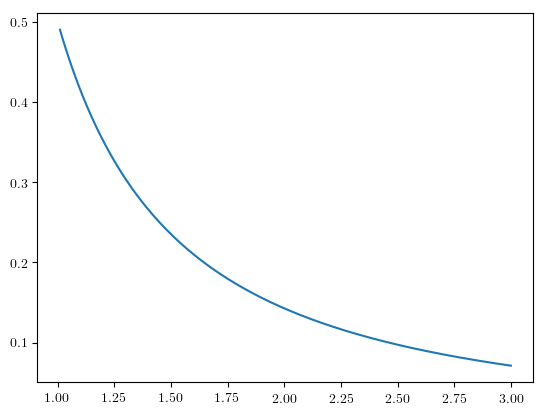

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x34ee5e610>

In [22]:
x= linspace(1,3,200)
plot(x,(2x.^2./(x.^2+2x-1)-1)./(x-1).^2)

In [24]:
methods(hypot)

# 32 methods for generic function "hypot":
hypot(a::Float16, b::Float16) at math.jl:486
hypot(x::BigFloat, y::BigFloat) at mpfr.jl:542
hypot{#583#A<:ForwardDiff.Dual{N,T<:Real},#584#B<:Union{AbstractFloat,Integer,Irrational{sym},Rational{T<:Integer}}}(a::ForwardDiff.Dual{0,#583#A}, b::ForwardDiff.Dual{0,#584#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:76
hypot{#608#A<:Union{AbstractFloat,Integer,Irrational{sym},Rational{T<:Integer}},#609#B<:ForwardDiff.Dual{N,T<:Real}}(a::ForwardDiff.Dual{0,#608#A}, b::ForwardDiff.Dual{0,#609#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:67
hypot{#569#A<:Real,#570#B<:Real}(a::ForwardDiff.Dual{0,#569#A}, b::ForwardDiff.Dual{0,#570#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:90
hypot{#587#M,#588#A<:ForwardDiff.Dual{N,T<:Real},#589#B<:Union{AbstractFloat,Integer,Irrational{sym},Rational{T<:Integer}}}(a::ForwardDiff.Dual{0,#588#A}, b::ForwardDiff.Dual{#587#M,#589#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:77
hypot{#612#M,#613#A<:Union{AbstractFloat,Integer,Irrational{sym},Rational{T<:Integer}},#614#B<:ForwardDiff.Dual{N,T<:Real}}(a::ForwardDiff.Dual{0,#613#A}, b::ForwardDiff.Dual{#612#M,#614#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:68
hypot{#573#M,#574#A<:Real,#575#B<:Real}(a::ForwardDiff.Dual{0,#574#A}, b::ForwardDiff.Dual{#573#M,#575#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:91
hypot{#592#N,#593#A<:ForwardDiff.Dual{N,T<:Real},#594#B<:Union{AbstractFloat,Integer,Irrational{sym},Rational{T<:Integer}}}(a::ForwardDiff.Dual{#592#N,#593#A}, b::ForwardDiff.Dual{0,#594#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:78
hypot{#617#N,#618#A<:Union{AbstractFloat,Integer,Irrational{sym},Rational{T<:Integer}},#619#B<:ForwardDiff.Dual{N,T<:Real}}(a::ForwardDiff.Dual{#617#N,#618#A}, b::ForwardDiff.Dual{0,#619#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:69
hypot{#578#N,#579#A<:Real,#580#B<:Real}(a::ForwardDiff.Dual{#578#N,#579#A}, b::ForwardDiff.Dual{0,#580#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:92
hypot{#597#N,#598#A<:ForwardDiff.Dual{N,T<:Real},#599#B<:Union{AbstractFloat,Integer,Irrational{sym},Rational{T<:Integer}}}(x::ForwardDiff.Dual{#597#N,#598#A}, y::ForwardDiff.Dual{#597#N,#599#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:79
hypot{#622#N,#623#A<:Union{AbstractFloat,Integer,Irrational{sym},Rational{T<:Integer}},#624#B<:ForwardDiff.Dual{N,T<:Real}}(x::ForwardDiff.Dual{#622#N,#623#A}, y::ForwardDiff.Dual{#622#N,#624#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:70
hypot{N}(x::ForwardDiff.Dual{N,T<:Real}, y::ForwardDiff.Dual{N,T<:Real}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:377
hypot{#602#N,#603#M,#604#A<:ForwardDiff.Dual{N,T<:Real},#605#B<:Union{AbstractFloat,Integer,Irrational{sym},Rational{T<:Integer}}}(x::ForwardDiff.Dual{#602#N,#604#A}, y::ForwardDiff.Dual{#603#M,#605#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:80
hypot{#627#N,#628#M,#629#A<:Union{AbstractFloat,Integer,Irrational{sym},Rational{T<:Integer}},#630#B<:ForwardDiff.Dual{N,T<:Real}}(x::ForwardDiff.Dual{#627#N,#629#A}, y::ForwardDiff.Dual{#628#M,#630#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:71
hypot{#563#N,#564#M,#565#A<:Real,#566#B<:Real}(a::ForwardDiff.Dual{#563#N,#565#A}, b::ForwardDiff.Dual{#564#M,#566#B}) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:88
hypot(x::ForwardDiff.Dual, y::ForwardDiff.Dual, z::ForwardDiff.Dual) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:381
hypot(x::ForwardDiff.Dual, y::ForwardDiff.Dual, z::Real) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:385
hypot(x::ForwardDiff.Dual, y::Real) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:378
hypot(x::Real, y::ForwardDiff.Dual) at /Users/johnwormell/.julia/v0.5/ForwardDiff/src/dual.jl:379
hypot(x::Real, y::ForwardDiff.Dual, z::ForwardDiff.Dual) at /Users/johnwormell/.ju